In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [1]:

import h5py
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from tensorflow.keras.layers import Input, Dense, Flatten, Reshape
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

def read_images_from_hdf5(hdf5_file_path):
    try:
        with h5py.File(hdf5_file_path, 'r') as hf:
            X = hf['X'][:]
            y = hf['y'][:]
            return X, y
    except Exception as e:
        print(f"Error reading HDF5 file: {e}")
        return None, None

df1= '/kaggle/input/classify/SingleElectronPt50_IMGCROPS_n249k_RHv1 (1).hdf5'
X1, y1 = read_images_from_hdf5(df1)
X1 = X1.astype('float32') / 255.
y1 = np.zeros(y1.shape[0])


df2 = '/kaggle/input/classify/SinglePhotonPt50_IMGCROPS_n249k_RHv1 (1) (1).hdf5'
X2, y2 = read_images_from_hdf5(df2)
X2 = X2.astype('float32') / 255.
y2 = np.ones(y2.shape[0])




In [2]:
# prompt: create df3 contain X and y

import numpy as np
X = np.concatenate((X1, X2), axis=0)
y = np.concatenate((y1, y2), axis=0)

dataset = (X, y)


In [16]:
import numpy as np
import cv2  # OpenCV for greyscaling

# Assuming X and y are NumPy arrays
# X = ... (your image data)
# y = ... (your labels)

if len(X.shape) == 4 and X.shape[-1] == 3:  # Check if it's a 4D RGB image
    # Greyscale each image in the batch
    X_greyscale = []
    for img in X:
        img_grey = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY) #or cv2.COLOR_BGR2GRAY if your images are in BGR order
        X_greyscale.append(img_grey)
    X = np.array(X_greyscale)
    X = np.expand_dims(X, axis=-1) # add a channel dimension to make it 4D again. (batch, height, width, 1)

if len(X.shape) == 4:
    X_reshaped = X.reshape(X.shape[0], -1)  # Flatten each image to a single vector
else:
    X_reshaped = X

# Perform Min-Max scaling for each pixel value across all images
min_val = np.min(X_reshaped)
max_val = np.max(X_reshaped)

if max_val == min_val:
    # Handle the case where all pixel values are the same to avoid division by zero
    X = np.zeros_like(X_reshaped, dtype=float)
else:
    X = (X_reshaped - min_val) / (max_val - min_val)

# Reshape back to the original image format if necessary
if len(X.shape) == 4:
    X = X.reshape(X.shape)

# Create the normalized dataset
dataset = (X, y)

# Now 'dataset' contains the greyscaled (if applicable) and Min-Max scaled data.
# The scaled X is now stored in the variable 'X'.

In [4]:
if len(X.shape) == 4:
    X_reshaped = X.reshape(X.shape[0], -1)  # Flatten each image to a single vector
else:
    X_reshaped = X

# Perform Min-Max scaling for each pixel value across all images
min_val = np.min(X_reshaped)
max_val = np.max(X_reshaped)

if max_val == min_val:
    # Handle the case where all pixel values are the same to avoid division by zero
    X = np.zeros_like(X_reshaped, dtype=float)
else:
    X = (X_reshaped - min_val) / (max_val - min_val)

# Reshape back to the original image format if necessary
if len(X.shape) == 4:
    X = X.reshape(X.shape)

# Create the normalized dataset
dataset = (X, y)

In [22]:
#exp
#try
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, random_split
import numpy as np

class BasicBlock(nn.Module):
    expansion = 1

    def __init__(self, in_planes, planes, stride=1):
        super(BasicBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_planes, planes, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_planes != self.expansion * planes:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_planes, self.expansion * planes, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(self.expansion * planes)
            )

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += self.shortcut(x)
        out = F.relu(out)
        return out

class ResNet15Approx(nn.Module):
    def __init__(self, num_classes=1, input_channels=2):
        super(ResNet15Approx, self).__init__()
        self.in_planes = 32 #reduced from 64
        self.conv1 = nn.Conv2d(input_channels, 32, kernel_size=3, stride=1, padding=1, bias=False) #reduced from 64
        self.bn1 = nn.BatchNorm2d(32)
        self.layer1 = self._make_layer(BasicBlock, 32, 1, stride=1) #reduced from 64
        self.layer2 = self._make_layer(BasicBlock, 64, 1, stride=2) #reduced from 128
        self.layer3 = self._make_layer(BasicBlock, 64, 1, stride=2) #reduced from 256
        self.layer4 = self._make_layer(BasicBlock, 64, 1, stride=2) #reduced from 512

        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.linear = nn.Linear(256 * BasicBlock.expansion, num_classes) #reduced from 512
        self.sigmoid = nn.Sigmoid()  # For binary classification

    def _make_layer(self, block, planes, num_blocks, stride):
        strides = [stride] + [1]*(num_blocks-1)
        layers = []
        for stride in strides:
            layers.append(block(self.in_planes, planes, stride))
            self.in_planes = planes * block.expansion
        return nn.Sequential(*layers)

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = self.avgpool(out)
        out = out.view(out.size(0), -1)
        out = self.linear(out)
        out = self.sigmoid(out) # Apply sigmoid for binary output
        return out



In [25]:
#try
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, random_split
import numpy as np

class BasicBlock(nn.Module):
    expansion = 1

    def __init__(self, in_planes, planes, stride=1):
        super(BasicBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_planes, planes, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_planes != self.expansion * planes:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_planes, self.expansion * planes, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(self.expansion * planes)
            )

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += self.shortcut(x)
        out = F.relu(out)
        return out

class ResNet15Approx(nn.Module):
    def __init__(self, num_classes=1, input_channels=2):
        super(ResNet15Approx, self).__init__()
        self.in_planes = 32 #reduced from 64
        self.conv1 = nn.Conv2d(input_channels, 32, kernel_size=3, stride=1, padding=1, bias=False) #reduced from 64
        self.bn1 = nn.BatchNorm2d(32)
        self.layer1 = self._make_layer(BasicBlock, 32, 1, stride=1) #reduced from 64
        self.layer2 = self._make_layer(BasicBlock, 64, 1, stride=2) #reduced from 128
        self.layer3 = self._make_layer(BasicBlock, 128, 1, stride=2) #reduced from 256
        self.layer4 = self._make_layer(BasicBlock, 256, 1, stride=2) #reduced from 512

        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.linear = nn.Linear(256 * BasicBlock.expansion, num_classes) #reduced from 512
        self.sigmoid = nn.Sigmoid()  # For binary classification

    def _make_layer(self, block, planes, num_blocks, stride):
        strides = [stride] + [1]*(num_blocks-1)
        layers = []
        for stride in strides:
            layers.append(block(self.in_planes, planes, stride))
            self.in_planes = planes * block.expansion
        return nn.Sequential(*layers)

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = self.avgpool(out)
        out = out.view(out.size(0), -1)
        out = self.linear(out)
        out = self.sigmoid(out) # Apply sigmoid for binary output
        return out



In [4]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, random_split
import numpy as np

class BasicBlock(nn.Module):
    expansion = 1

    def __init__(self, in_planes, planes, stride=1):
        super(BasicBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_planes, planes, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_planes != self.expansion * planes:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_planes, self.expansion * planes, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(self.expansion * planes)
            )

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += self.shortcut(x)
        out = F.relu(out)
        return out

class ResNet15Approx(nn.Module):
    def __init__(self, num_classes=1, input_channels=2): #binary classification, 2 channels
        super(ResNet15Approx, self).__init__()
        self.in_planes = 64
        self.conv1 = nn.Conv2d(input_channels, 64, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.layer1 = self._make_layer(BasicBlock, 64, 2, stride=1) # Changed num_blocks to 2
        self.layer2 = self._make_layer(BasicBlock, 128, 2, stride=2) # Changed num_blocks to 2
        self.layer3 = self._make_layer(BasicBlock, 256, 2, stride=2) # Changed num_blocks to 2
        self.layer4 = self._make_layer(BasicBlock, 512, 1, stride=2)

        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.linear = nn.Linear(512 * BasicBlock.expansion, num_classes)
        self.sigmoid = nn.Sigmoid()  # For binary classification

    def _make_layer(self, block, planes, num_blocks, stride):
        strides = [stride] + [1]*(num_blocks-1)
        layers = []
        for stride in strides:
            layers.append(block(self.in_planes, planes, stride))
            self.in_planes = planes * block.expansion
        return nn.Sequential(*layers)

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = self.avgpool(out)
        out = out.view(out.size(0), -1)
        out = self.linear(out)
        out = self.sigmoid(out) # Apply sigmoid for binary output
        return out



In [5]:
class CustomDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.tensor(X, dtype=torch.float32).permute(0, 3, 1, 2) # NCHW format
        self.y = torch.tensor(y, dtype=torch.float32).view(-1, 1) # Ensure y is a column vector

    def __len__(self):
        return len(self.y)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

# Example usage:
X = np.random.rand(498000, 32, 32, 2)
y = np.random.randint(0, 2, 498000)

dataset = CustomDataset(X, y)




In [6]:

train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size
train_dataset, test_dataset = random_split(dataset, [train_size, test_size])

train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=128, shuffle=False)



In [6]:
net = ResNet15Approx()

In [7]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, random_split
import numpy as np
import time

In [28]:
net = ResNet15Approx().cuda()  # Move the model to the GPU
criterion = nn.BCELoss().cuda() #Move loss to GPU.

In [29]:
optimizer = optim.Adam(net.parameters(), lr=0.001)

num_epochs = 10

In [15]:
optimizer = optim.Adam(net.parameters(), lr=0.001)

num_epochs = 10

for epoch in range(num_epochs):
    net.train()
    running_loss = 0.0
    start_time = time.time()
    for inputs, labels in train_loader:
        inputs, labels = inputs.cuda(), labels.cuda()  # Move data to GPU
        optimizer.zero_grad()
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

    epoch_time = time.time() - start_time
    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {running_loss / len(train_loader):.4f}, Time: {epoch_time:.2f}s')


KeyboardInterrupt: 

In [9]:
import torch

if torch.cuda.is_available():
    print("CUDA is available!")
    device = torch.device("cuda")
    print(f"Using GPU: {torch.cuda.get_device_name(0)}")
else:
    print("CUDA is NOT available. Check your installation!")
    device = torch.device("cpu") #If cuda is not available, use cpu.

CUDA is available!
Using GPU: Tesla P100-PCIE-16GB


In [18]:
import torch
from torch.utils.data import TensorDataset, DataLoader, random_split
import numpy as np

# Assuming X and y are NumPy arrays
X = np.random.rand(498000, 32, 32, 2)
y = np.random.randint(0, 2, 498000)

# Convert NumPy arrays to PyTorch tensors
X_tensor = torch.tensor(X, dtype=torch.float32).permute(0, 3, 1, 2)
y_tensor = torch.tensor(y, dtype=torch.float32).view(-1, 1)

# Create TensorDataset
dataset = TensorDataset(X_tensor, y_tensor)

# Split dataset
train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size
train_dataset, test_dataset = random_split(dataset, [train_size, test_size])

# Create DataLoaders
train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True, num_workers=4, pin_memory=True)
test_loader = DataLoader(test_dataset, batch_size=128, shuffle=False, num_workers=4, pin_memory=True)

In [47]:


net = ResNet15Approx().cuda() # Move model to GPU
criterion = nn.BCELoss().cuda() # Move loss to GPU
optimizer = optim.Adam(net.parameters(), lr=0.001)

num_epochs = 10


In [27]:

for epoch in range(num_epochs):
    net.train()
    running_loss = 0.0
    start_time = time.time()
    for inputs, labels in train_loader:
        inputs, labels = inputs.cuda(), labels.cuda() # Move data to GPU


        #print(f"Input device: {inputs.device}, Label device: {labels.device}")
 
        optimizer.zero_grad()
        outputs = net(inputs)
        #print(f"Output device: {outputs.device}, Model weight device: {next(net.parameters()).device}")

        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

    epoch_time = time.time() - start_time
    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {running_loss / len(train_loader):.4f}, Time: {epoch_time:.2f}s')



Epoch [1/10], Loss: 0.6945, Time: 54.00s
Epoch [2/10], Loss: 0.6936, Time: 53.77s
Epoch [3/10], Loss: 0.6933, Time: 54.54s
Epoch [4/10], Loss: 0.6930, Time: 53.59s
Epoch [5/10], Loss: 0.6927, Time: 53.72s
Epoch [6/10], Loss: 0.6915, Time: 54.08s
Epoch [7/10], Loss: 0.6884, Time: 53.79s
Epoch [8/10], Loss: 0.6815, Time: 53.69s
Epoch [9/10], Loss: 0.6687, Time: 54.04s
Epoch [10/10], Loss: 0.6491, Time: 53.80s


In [30]:
net.eval()  # Set the model to evaluation mode
with torch.no_grad():  # Disable gradient calculation for evaluation
    correct = 0
    total = 0
    for inputs, labels in test_loader:
        inputs, labels = inputs.cuda(), labels.cuda()  # Move test data to GPU
        outputs = net(inputs)
        predicted = (outputs > 0.5).float()  # Threshold at 0.5 for binary classification
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    accuracy = 100 * correct / total
    print(f'Test Accuracy: {accuracy:.2f}%')

Test Accuracy: 49.81%


In [28]:
num_epochs = 4
for epoch in range(num_epochs):
    net.train()
    running_loss = 0.0
    start_time = time.time()
    for inputs, labels in train_loader:
        inputs, labels = inputs.cuda(), labels.cuda() # Move data to GPU


        #print(f"Input device: {inputs.device}, Label device: {labels.device}")
 
        optimizer.zero_grad()
        outputs = net(inputs)
        #print(f"Output device: {outputs.device}, Model weight device: {next(net.parameters()).device}")

        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

    epoch_time = time.time() - start_time
    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {running_loss / len(train_loader):.4f}, Time: {epoch_time:.2f}s')



Epoch [1/4], Loss: 0.6214, Time: 54.15s
Epoch [2/4], Loss: 0.5858, Time: 53.65s
Epoch [3/4], Loss: 0.5423, Time: 53.22s
Epoch [4/4], Loss: 0.4922, Time: 53.97s


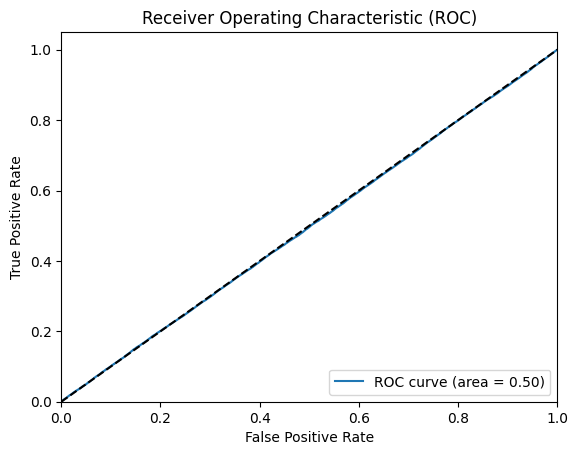

In [29]:
import time
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
net.eval()  # Set the model to evaluation mode
with torch.no_grad():  # Disable gradient calculation for evaluation
    all_labels = []
    all_probs = []
    for inputs, labels in test_loader:
        inputs, labels = inputs.cuda(), labels.cuda()  # Move test data to GPU
        outputs = net(inputs)
        all_labels.extend(labels.cpu().numpy())
        all_probs.extend(outputs.cpu().numpy())

    fpr, tpr, thresholds = roc_curve(np.array(all_labels), np.array(all_probs))
    roc_auc = auc(fpr, tpr)

    plt.figure()
    plt.plot(fpr, tpr, label=f'ROC curve (area = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC)')
    plt.legend(loc="lower right")
    plt.show()

**#RES18**# 


In [43]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision import models, transforms
import numpy as np

# Define a custom dataset class
class PhotonElectronDataset(Dataset):
    def __init__(self, X, y, transform=None):
        self.X = torch.tensor(X, dtype=torch.float32)
        self.y = torch.tensor(y, dtype=torch.float32).unsqueeze(1) # Reshape y for binary cross-entropy
        self.transform = transform

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        sample = self.X[idx]
        label = self.y[idx]
        if self.transform:
            # Apply transformations if needed, for image-like data
            # Assuming your data is like (batch_size, 32, 32, 2)
            # You might need to adjust the transform to handle the 2 channels
            sample = self.transform(sample.permute(2, 0, 1)) # (2, 32, 32)
            sample = sample.unsqueeze(0) # (1, 2, 32, 32) - ResNet expects (batch_size, channels, height, width)
        return sample, label

# Load your data
# Assuming X and y are numpy arrays
# X shape: (498000, 32, 32, 2)
# y shape: (498000,)
# Replace this with your actual data loading
# For demonstration, let's create dummy data
num_samples = 498000
img_size = 32
num_channels = 2
X_dummy = np.random.rand(num_samples, img_size, img_size, num_channels)
y_dummy = np.random.randint(0, 2, num_samples) # Binary labels (0 or 1)

# Define transformations (if needed for ResNet input)
# ResNet models typically expect 3-channel images (RGB)
# You might need to adapt the input to match this or modify the first layer
transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((224, 224)), # ResNet input size
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]) # ImageNet normalization
])

# Create the dataset
dataset = PhotonElectronDataset(X_dummy, y_dummy, transform=transform)

# Split the dataset into training and validation sets
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

# Create DataLoaders


# Load a pretrained ResNet-18 model


In [44]:
batch_size = 256

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size)

In [45]:
model = models.resnet18(pretrained=True)
num_channels=2
# Modify the first convolutional layer to accept 2 input channels
# Get the number of input channels of the first layer
in_channels = model.conv1.in_channels
if in_channels != num_channels:
    model.conv1 = nn.Conv2d(num_channels, 64, kernel_size=7, stride=2, padding=3, bias=False)

# Modify the final fully connected layer for binary classification
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, 1)

# Define the loss function and optimizer
criterion = nn.BCEWithLogitsLoss() # Use BCEWithLogitsLoss for numerical stability
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Move the model to the device (CPU or GPU)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)



ResNet(
  (conv1): Conv2d(2, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [48]:
# Training loop
num_epochs = 10 # You can adjust the number of epochs
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for i, (inputs, labels) in enumerate(train_loader):
        inputs = inputs.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()

        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

        if (i + 1) % 100 == 0:
            print(f'Epoch [{epoch+1}/{num_epochs}], Step [{i+1}/{len(train_loader)}], Loss: {running_loss/100:.4f}')
            running_loss = 0.0

    # Validation loop (optional but recommended)
    model.eval()
    with torch.no_grad():
        correct = 0
        total = 0
        val_loss = 0.0
        for inputs, labels in test_loader:
            inputs = inputs.to(device)
            labels = labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            val_loss += loss.item()
            predicted = torch.sigmoid(outputs) > 0.5
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
        print(f'Epoch [{epoch+1}/{num_epochs}], Validation Loss: {val_loss/len(test_loader):.4f}, Validation Accuracy: {100 * correct / total:.2f}%')

print('Finished Training')

# You can now save the trained model
# torch.save(model.state_dict(), 'resnet18_photon_electron_classifier.pth')

RuntimeError: The size of tensor a (2) must match the size of tensor b (3) at non-singleton dimension 0

In [5]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision import models, transforms
import numpy as np

# Define a custom dataset class
class PhotonElectronDataset(Dataset):
    def __init__(self, X, y, transform=None):
        self.X = torch.tensor(X, dtype=torch.float32)
        self.y = torch.tensor(y, dtype=torch.float32).unsqueeze(1) # Reshape y for binary cross-entropy
        self.transform = transform

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        sample = self.X[idx]
        label = self.y[idx]
        if self.transform:
            sample = sample.permute(2, 0, 1) # (2, 32, 32)
            sample = self.transform(sample)
            # print(f"Shape after transform: {sample.shape}") # You can keep this for debugging
            # if len(sample.shape) == 3: # Removed this condition and the next line
            #     sample = sample.unsqueeze(0)
        return sample, label

# Load your data
# Assuming X and y are numpy arrays
# X shape: (498000, 32, 32, 2)
# y shape: (498000,)
# Replace this with your actual data loading
# For demonstration, let's create dummy data
num_samples = 498000
img_size = 32
num_channels = 2
X_dummy = np.random.rand(num_samples, img_size, img_size, num_channels)
y_dummy = np.random.randint(0, 2, num_samples) # Binary labels (0 or 1)

# Define transformations (if needed for ResNet input)
# ResNet models typically expect 3-channel images (RGB)
# You might need to adapt the input to match this or modify the first layer
transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((224, 224)), # ResNet input size
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5], std=[0.5, 0.5]) # Adjusted for 2 channels
])

# Create the dataset
dataset = PhotonElectronDataset(X_dummy, y_dummy, transform=transform)

# Split the dataset into training and validation sets
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

# Create DataLoaders
batch_size = 128
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size)

# Load a pretrained ResNet-18 model
model = models.resnet18(pretrained=True)

# Modify the first convolutional layer to accept 2 input channels
# Get the number of input channels of the first layer
in_channels = model.conv1.in_channels
if in_channels != num_channels:
    model.conv1 = nn.Conv2d(num_channels, 64, kernel_size=7, stride=2, padding=3, bias=False)

# Modify the final fully connected layer for binary classification
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, 1)

# Define the loss function and optimizer
criterion = nn.BCEWithLogitsLoss() # Use BCEWithLogitsLoss for numerical stability
optimizer = optim.Adam(model.parameters(), lr=0.01)

# Move the model to the device (CPU or GPU)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)


ResNet(
  (conv1): Conv2d(2, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [6]:
# Training loop
num_epochs = 10 # You can adjust the number of epochs
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for i, (inputs, labels) in enumerate(train_loader):
        
    
        inputs = inputs.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()

        try:
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()

            if (i + 1) % 100 == 0:
                print(f'Epoch [{epoch+1}/{num_epochs}], Step [{i+1}/{len(train_loader)}], Loss: {running_loss/100:.4f}')
                running_loss = 0.0
        except RuntimeError as e:
            print(f"RuntimeError during forward/backward pass at epoch {epoch+1}, step {i+1}: {e}")
            print(f"Input shape: {inputs.shape}")
            print(f"Expected input shape for ResNet: (batch_size, channels, height, width)")
            continue # Skip this batch and continue with the next

    # Validation loop (optional but recommended)
    model.eval()
    with torch.no_grad():
        correct = 0
        total = 0
        val_loss = 0.0
        for inputs, labels in val_loader:
            inputs = inputs.to(device)
            labels = labels.to(device)
            try:
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                val_loss += loss.item()
                predicted = torch.sigmoid(outputs) > 0.5
                total += labels.size(0)
                correct += (predicted == labels).sum().item()
            except RuntimeError as e:
                print(f"RuntimeError during validation at epoch {epoch+1}: {e}")
                print(f"Input shape during validation: {inputs.shape}")
                continue # Skip this batch

        print(f'Epoch [{epoch+1}/{num_epochs}], Validation Loss: {val_loss/len(val_loader):.4f}, Validation Accuracy: {100 * correct / total:.2f}%')

print('Finished Training')

# You can now save the trained model
# torch.save(model.state_dict(), 'resnet18_photon_electron_classifier.pth')

Epoch [1/10], Step [100/3113], Loss: 0.7504
Epoch [1/10], Step [200/3113], Loss: 0.7046
Epoch [1/10], Step [300/3113], Loss: 0.7000
Epoch [1/10], Step [400/3113], Loss: 0.6949
Epoch [1/10], Step [500/3113], Loss: 0.6960
Epoch [1/10], Step [600/3113], Loss: 0.6950
Epoch [1/10], Step [700/3113], Loss: 0.6939
Epoch [1/10], Step [800/3113], Loss: 0.6938
Epoch [1/10], Step [900/3113], Loss: 0.6936
Epoch [1/10], Step [1000/3113], Loss: 0.6937
Epoch [1/10], Step [1100/3113], Loss: 0.6933
Epoch [1/10], Step [1200/3113], Loss: 0.6933
Epoch [1/10], Step [1300/3113], Loss: 0.6932
Epoch [1/10], Step [1400/3113], Loss: 0.6932
Epoch [1/10], Step [1500/3113], Loss: 0.6933
Epoch [1/10], Step [1600/3113], Loss: 0.6932
Epoch [1/10], Step [1700/3113], Loss: 0.6934
Epoch [1/10], Step [1800/3113], Loss: 0.6933
Epoch [1/10], Step [1900/3113], Loss: 0.6933
Epoch [1/10], Step [2000/3113], Loss: 0.6933
Epoch [1/10], Step [2100/3113], Loss: 0.6933
Epoch [1/10], Step [2200/3113], Loss: 0.6930
Epoch [1/10], Step 

KeyboardInterrupt: 